In [1]:
using FileIO
using Plots
include("splitcell.jl")
include("segmentation3d.jl")
include("normalization3d.jl")
include("tiffxml.jl")

embedxml

In [2]:
d16s1 = load(File(format"TIFF", "../mRNA_confocal_hamamatsu-60X-TIRF/20200316/HE7-11-1-80uw-PWM_1_s1.ome.tiff"));

In [3]:
@time mask_markers  = split_cell_LoG(d16s1, 138);

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 243.376357 seconds (32.69 M allocations: 63.494 GiB, 12.08% gc time)


In [46]:
# Get living time
livingtime(stack) = [ sum(stack[:, :, i])>0 for i in 1:size(stack)[3] ]
area_t(stack) = [ sum(stack[:, :, i]) for i in 1:size(stack)[3] ]
"""
function component_lengths(img::AbstractArray{Int})
    n = zeros(Int64,maximum(img)+1)
    for i=1:length(img)
        n[img[i]+1]+=1
    end
    n
end
"""
function get_unique_label(_old_labels)
    i = 100 # start from 100 to distiguish with oldest labels
    while(true)
        if i in _old_labels
            i+=1
        else
            break
        end
    end
    i
end

# Find long-lived trajactory
function find_time_line(markers_t)
    # search connected components in 3D space 
    shortest_t = 110
    print("Finding connected component")
    @time time_line = label_components( markers_t.>0 )
    time_line_whole = copy(time_line)
    line_amount = maximum(time_line)
    # More advanced and fine punch and merge could be done
    # But we just select long living trajactory, remove short-lived one
    living_time =[ livingtime(time_line.==line) for line in 1:line_amount ]
    living_length = [sum(living_time[line]) for line in 1:line_amount]
    # label 0 mean background
    shortlived = living_length .< shortest_t
    longlived_label = (1:line_amount)[.~shortlived]
    #longlived_time = living_time[]
    for line in (1:line_amount)[shortlived]
        time_line .*= (time_line.≠line)
    end
    time_line, longlived_label, living_time[longlived_label], time_line_whole
end

find_time_line (generic function with 1 method)

Finding connected component  3.223885 seconds (74 allocations: 2.898 GiB, 6.14% gc time)
 93.066825 seconds (2.09 M allocations: 15.281 GiB, 1.42% gc time)


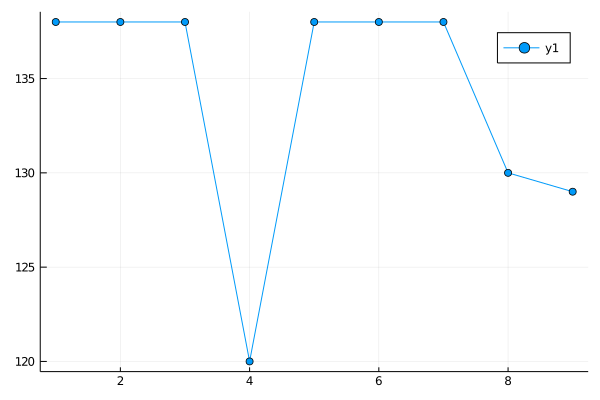

In [47]:
@time time_line_1, longlived_labels_1, livingtime_1, time_line_whole_1 = find_time_line(mask_markers);
plot(sum.(livingtime_1), marker=:circle)

  3.386070 seconds (251.58 k allocations: 743.622 MiB, 1.55% gc time)


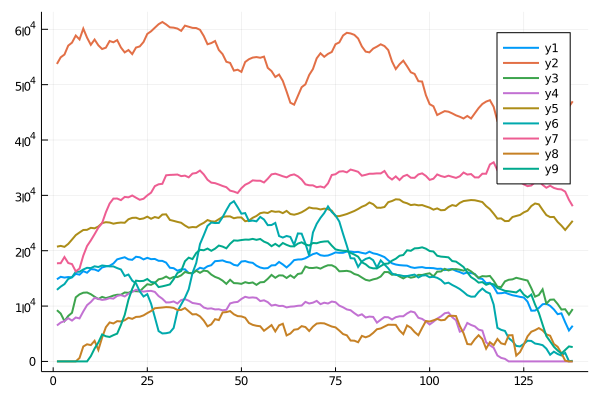

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un

In [11]:
@time area_longlived = [area_t( time_line_1 .== i)  for i in longlived_labels_1];
plot(area_longlived, lw=2)

In [6]:
#for old_label in old_labels
function split_contacted_cell!(old_time_line::Array{Int64,3}, 
        old_longlived_labels::Array{Int64,1}, old_living_time::Array{Array{Bool,1},1},
        old_time_line_whole::Array{Int64, 3} )
    t_len = size(old_time_line)[3]
    
    println("Detecting contacted branch")
    conn_z_number = []; # mark connected components more than 1
    for label in old_longlived_labels
        branches = old_time_line .== label
        push!(conn_z_number, [maximum(label_components(branches[:,:, i])) .> 1 for i in 1:t_len])
    end
    contacted_labels = old_longlived_labels[sum.(conn_z_number) .> 10]
    print("Found contacted branch: ")
    println(contacted_labels)
    # if two more connected component touch to at same z slice more than 10 times
    # select area longer than 5e4
    #old_label = longlived_label_2[mean.(area_longlived) .> 5e4 ]
    
    # split 3d branch by split 2d cell slice by slice
    for contacted_label in contacted_labels
        dist_const = 30 # distance constant 
        contacted_branch = old_time_line .==  contacted_label
        dist  = zeros(size( contacted_branch ))
        local_markers = zeros(Bool, size( contacted_branch ))
        println("Splitting branch $contacted_label now")
        for  t in 1:t_len # TODO: only split when connected component descrease
            dist[:,:, t] = distance_transform(feature_transform(.~contacted_branch[:,:,t]))
            local_markers[:,:,t] = dist[:,:,t] .> dist_const
            #split_water = watershed( .- dist[:,:,t], label_components(markers[:,:,t]))
            # 直接用 dist 可能会错误打断完整轨迹，需额外膨胀
            # 用分水岭 可能会误连，需额外腐蚀
        end
        local_time_line, local_longlived_labels, local_living_time, local_time_line_whole = find_time_line( local_markers );
        
        println("Reassigning contacted branch $contacted_label ")
        # Assign new label to labels set and update mask
        if length(local_longlived_labels) > 0
            #TODO: what if all lines are shorter than 90 after breaking
            # remove old branch, old label, old living time.
            old_time_line .-= (( old_time_line .== contacted_label ).*contacted_label)
            old_time_line_whole  .-= (( old_time_line .== contacted_label ).*contacted_label)
            index2remove =  old_longlived_labels .== contacted_label
            deleteat!( old_longlived_labels, index2remove )
            deleteat!( old_living_time, index2remove)
            for i in 1:length(local_longlived_labels)
                global_label = get_unique_label(old_longlived_labels)
                old_time_line .+= ((local_time_line .== local_longlived_labels[i]) .* global_label)
                old_time_line_whole .+= ((local_time_line .== local_longlived_labels[i]) .* global_label)
                push!( old_longlived_labels, global_label )
                push!( old_living_time, local_living_time[i] )
                println("Branch $contacted_label -> $global_label")
            end
            # add marker to time_line_whole
            for i in 1:maximum(local_time_line_whole)
                if i ∉ longlived_labels_1
                    global_label = get_unique_label(1:maximum(old_time_line_whole))
                    old_time_line_whole .+=  ((local_time_line .== i) .* global_label)
                end
            end
        end
    end
    # Should we return area_t rather than area_t.>0
    old_time_line, old_longlived_labels, old_living_time, old_time_line_whole
end

split_contacted_cell! (generic function with 1 method)

In [48]:
@time split_contacted_cell!(time_line_1, longlived_labels_1, livingtime_1, time_line_whole_1);

Detecting contacted branch
Found contacted branch: [8, 13]
Splitting branch 8 now
Finding connected component  2.650021 seconds (72 allocations: 2.897 GiB, 0.64% gc time)
Reassigning contacted branch 8 
Branch 8 -> 100
Branch 8 -> 101
Branch 8 -> 102
Splitting branch 13 now
Finding connected component  2.744006 seconds (70 allocations: 2.897 GiB, 0.46% gc time)
Reassigning contacted branch 13 
155.785068 seconds (1.74 M allocations: 69.152 GiB, 4.26% gc time)


In [61]:
"`component_centroids(labeled_array)` -> an array of centroids for selected lables, excluding the background label 0"
function component_centroids_lables(img::AbstractArray{Int,N}, labels::AbstractArray{Int, 1}, max_index::Integer) where N
    len = length(0:maximum(max_index))
    #len = length(0:maximum(labels))
    n = fill(zero(CartesianIndex{N}), len)
    counts = fill(0, len)
    @inbounds for I in CartesianIndices(size(img))
        v = img[I] + 1
        n[v] += I
        counts[v] += 1
    end
    map(v -> n[v].I ./ counts[v], labels.+1)
end

"extract walking pathway"
function walking(_time_line, _longlived_labels, _livingtime)
    _tracks = zeros( 2, length(_livingtime[1]), length(_longlived_labels))
    _max_index = maximum(_time_line)
    @inbounds for t in 1: length(_livingtime[1])
        tmp = component_centroids_lables(_time_line[:, :, t], _longlived_labels, _max_index)
        @inbounds for i in 1:length(_longlived_labels)
            _tracks[:, t, i] = [tmp[i][1]  tmp[i][2]]
        end
    end
    _tracks #[pos, t, branch]
    #TODO: soomth pathway to make sence in biology
end

walking

In [63]:
tracks = walking(time_line_1, longlived_labels_1, livingtime_1);

In [123]:
" Return box with fixed height and width"
function box(_center, _d₁max, _d₂max)
    α = 256 
    Α = 2*α 
    d₁, d₂ = Int.(floor.(_center))
    d₁min, d₁max, d₂min, d₂max = d₁-α+1, d₁+α,  d₂-α+1, d₂+α
    if d₁min < 1
        d₁max = Α
        d₁min = 1
    end
    if d₁max > _d₁max
        d₁min = _d₁max - Α + 1
        d₁max = _d₁max 
    end
    if d₂min < 1
        d₂max = Α
        d₂min = 1
    end
    if d₂max > _d₂max
        d₂min = _d₂max - Α + 1
        d₂max = _d₂max
    end
    d₁min:d₁max, d₂min:d₂max
end


" 分封领地"
function grant_domain( _raw_imgs, _time_line, _longlived_labels, _livingtime, _time_line_whole)
    z_depth = 20
    t_len = length(_livingtime[1])
    h, w = size(_raw_imgs[:,:,1]);
    watershed_maps = zeros(Integer, h, w, t_len)
    # watershed here?
    println("Grant domain for each detected cell by watershed")
    @inbounds for t in 1:t_len # TODO: mulit-processing
        print("$t ")
        watershed_maps[:, :, t] = labels_map(watershed(
                .-maximum(_raw_imgs[:,:,z_depth*(t-1)+1:z_depth*t],dims=3)[:,:,1], _time_line_whole[:,:,t]) )
    end
    
    longlived_maps = zeros(Integer, h, w, t_len)
    @inbounds for i in 1:length(_longlived_labels)
        label = _longlived_labels[i]
        print("$label ")
        for t in (1:t_len)[_livingtime[i]] # only choose frame when object exist
                longlived_maps[:, :, t] .+= (watershed_maps[:, :, t] .== label).*label
        end
    end    
    longlived_maps
end

" Using given mask to export roi of cell "
function pick_cells( _raw_imgs, _longlived_maps, _index, _tracks, _longlived_labels, _livingtime)
    z_depth = 20
    t_len = length(_livingtime[1])
    h, w = size(_raw_imgs[:, :, 1])
    # Get centroids for each label
    cell_img = zeros(512, 512, t_len*z_depth)
    #print("$_index ")
    
    for t in (1:t_len)[_livingtime[_index]] # only choose frame when object exist
        bounder = box(_tracks[:, t, _index], h, w)
        cell_img[:, :, (t-1)*z_depth+1:t*z_depth] =  # how can I assign value directly instead of using .*
                _raw_imgs[bounder[1], bounder[2], (t-1)*z_depth+1:t*z_depth] .*
                (_longlived_maps[bounder[1], bounder[2], t] .== _longlived_labels[_index])
                #(_time_line[bounder[1], bounder[2], t] .== label)      
    end
    cell_img
end

pick_cells

In [ ]:
@time d16s1_longlived_maps = grant_domain(d16s1, time_line_1, longlived_labels_1, livingtime_1, time_line_whole_1);

In [119]:
tracks = walking(time_line_1, longlived_labels_1, livingtime_1);

In [124]:
@time d16s1_1 = pick_cells(d16s1, d16s1_longlived_maps, 1, tracks, longlived_labels_1, livingtime_1);

141.438720 seconds (1.45 G allocations: 29.960 GiB, 62.26% gc time)


In [230]:
@time d16s1_2 = pick_cells(d16s1, d16s1_longlived_maps, 2, tracks, longlived_labels_1, livingtime_1);

134.988423 seconds (1.45 G allocations: 29.923 GiB, 63.65% gc time)


In [232]:
@time save("d16s1_2.tiff", N0f16.(d16s1_2));
embedxml(512, 512, 20, 138, "d16s1_2.tiff")

Embedding OME-XML    1 image files updated


In [239]:
@time for i in 1:138*20
    d16s1_2[:,:,i] = mapwindow(median!, d16s1_2[:, :, i], (5, 5));
end

272.135114 seconds (202.81 M allocations: 21.527 GiB, 2.52% gc time)


In [246]:
@time d16s1_2 = pick_cells(d16s1, d16s1_longlived_maps, 2, tracks, longlived_labels_1, livingtime_1);
@time for i in 1:138*20
    d16s1_2[:,:,i] = imfilter( d16s1_2[:, :, i], Kernel.gaussian(3), );
end

133.392077 seconds (1.45 G allocations: 29.923 GiB, 63.77% gc time)
 37.267248 seconds (4.01 M allocations: 16.725 GiB, 5.87% gc time)


In [247]:
@time d16s1_2_nu, d16s1_2_th = extract3dnucleus(d16s1_2);
@time save("d16s1_2_clear_gs.tiff", N0f16.(d16s1_2_nu));
embedxml(512, 512, 20, 138, "d16s1_2_clear_gs.tiff")

230.940714 seconds (256.83 k allocations: 32.643 GiB, 69.90% gc time)
 36.562383 seconds (81 allocations: 4.043 GiB, 3.51% gc time)
Embedding OME-XML    1 image files updated


In [240]:
@time d16s1_2_nu, d16s1_2_th = extract3dnucleus(d16s1_2);
@time save("d16s1_2_clear.tiff", N0f16.(d16s1_2_nu));
embedxml(512, 512, 20, 138, "d16s1_2_clear.tiff")

235.555500 seconds (256.83 k allocations: 32.643 GiB, 70.16% gc time)
 38.935386 seconds (81 allocations: 4.043 GiB, 2.97% gc time)
Embedding OME-XML    1 image files updated


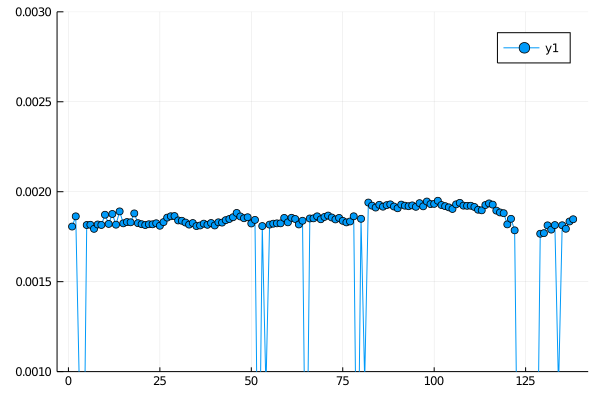

In [248]:
plot(d16s1_2_th, marker=:circle)
plot!(ylim=(0.001, 0.003))

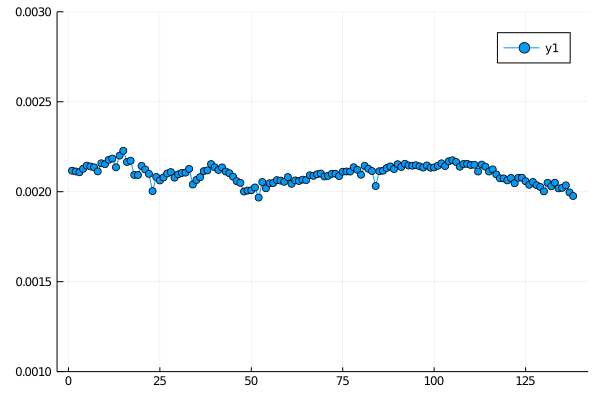

In [162]:
plot(d16s1_1_th, marker=:circle)
plot!(ylim=(0.001, 0.003))

In [139]:
@time save("d16s1_1_clear.tiff", N0f16.(d16s1_1_nu));
embedxml(512, 512, 20, 138, "d16s1_1_clear.tiff")

 37.921791 seconds (81 allocations: 4.043 GiB, 2.68% gc time)
Embedding OME-XML    1 image files updated


In [142]:
d16s1_1_nu_nor, para = normalize(d16s1_1_nu);
@time save("d16s1_1_clear_nor.tiff", N0f16.(d16s1_1_nu_nor));
embedxml(512, 512, 20, 138, "d16s1_1_clear_nor.tiff")

no cell in time point 131
no cell in time point 134
 34.773646 seconds (81 allocations: 4.043 GiB, 0.05% gc time)
Embedding OME-XML    1 image files updated


In [157]:
medianfilter1(v, ws) = [median(v[i:(i+ws-1)]) for i=1:(length(v)-ws+1) ]
medianfilter(v, ws) = medianfilter1(vcat(0,v,0),ws)

medianfilter (generic function with 1 method)

In [149]:
yen_th =[ yen_threshold(d16s1_1[:,:,1+20*(t-1):20*t][d16s1_1[:,:,1:20].>0])  for t in 1:138];

In [167]:
yen_th_meidan =[ yen_threshold(mapwindow(median!,d16s1_1[:,:,1+20*(t-1):20*t], (5,5,5))[d16s1_1[:,:,1:20].>0])  for t in 1:138];

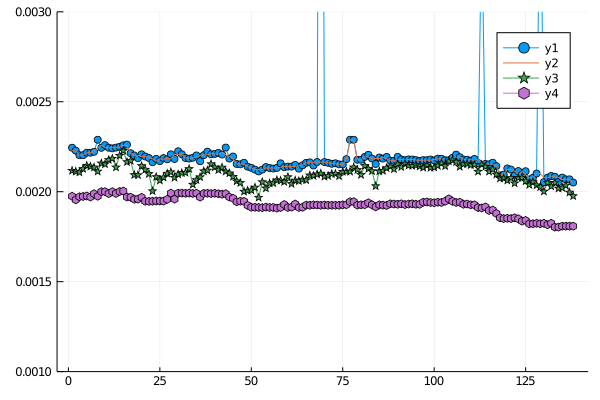

In [168]:
plot(yen_th, marker=:circle, ylim=(0.001,0.003))
plot!(medianfilter(yen_th, 3))
plot!(d16s1_1_th, marker=:star)
plot!(yen_th_meidan, marker=:hex)

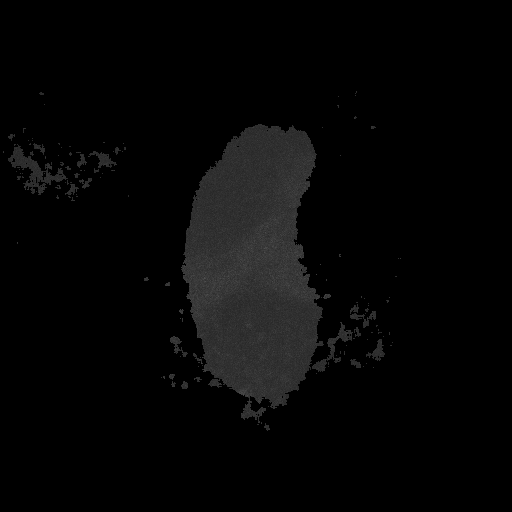

In [223]:
Gray.((d16s1_1[:,:,16].*((mapwindow(median!, d16s1_1[:,:,20*39+14],(5,5)).>yen_th_meidan[39]))).*100)

In [156]:
img = mapwindow(median!, maximum(d16s1_cel[6][:,:,20*16+1:20*17], dims=3)[:,:,1], (5,5));

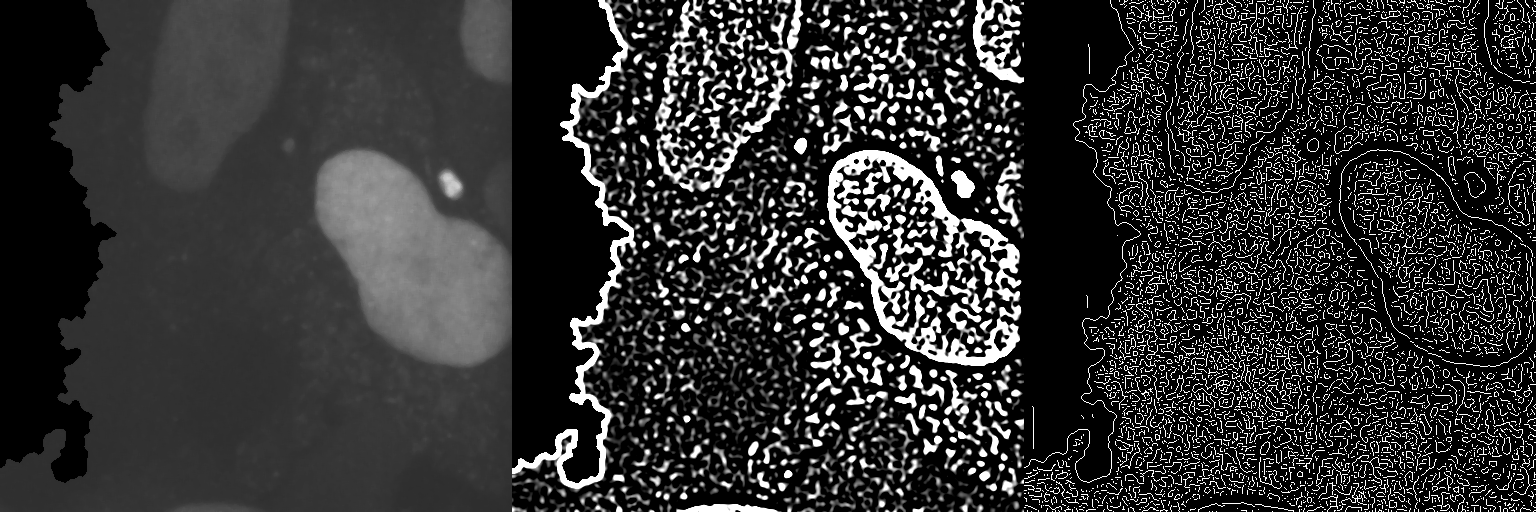

In [175]:
[Gray.(img.*100) Gray.(imfilter(img, Kernel.DoG(2)).*100000) Gray.(time_line_2[]) ] 

In [233]:
rage_6_16 = box(para["tracks"][:,16, 6], 1900, 1300);

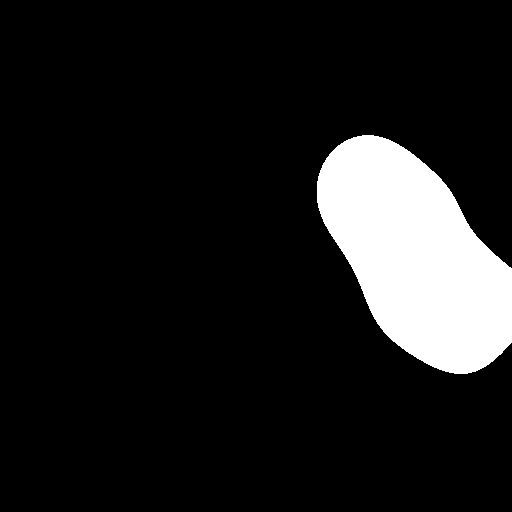

In [236]:
mask_6_16 =(time_line_2[:,:, 16] .== longlived_label_2[6])[rage_6_16[1], rage_6_16[2]]
Gray.((time_line_2[:,:, 16] .== longlived_label_2[6])[rage_6_16[1], rage_6_16[2]])

In [271]:
 0.002*0xffff

131.07

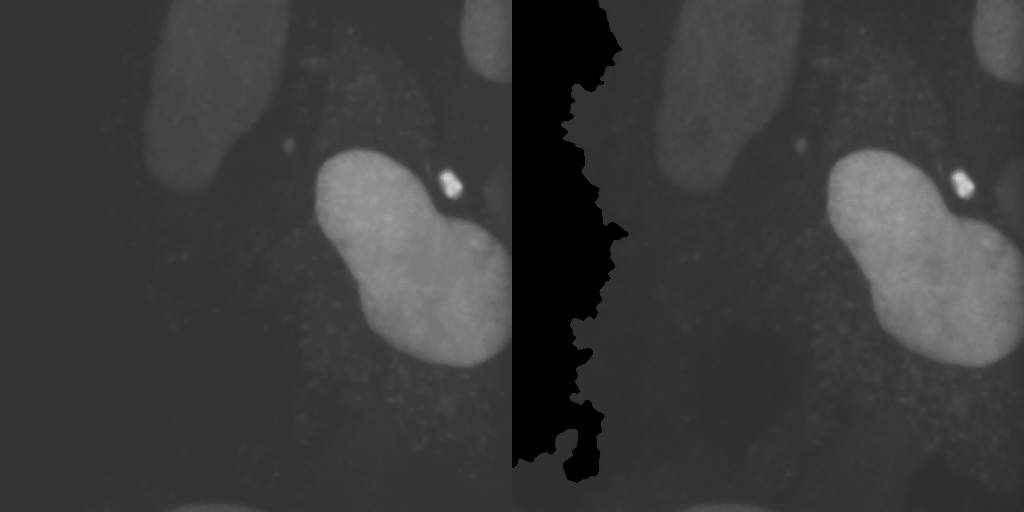

In [272]:
[Gray.(hmin_transform(img, 0.002).*100) Gray.(img.*100)]

In [ ]:
watershed(.-img, )

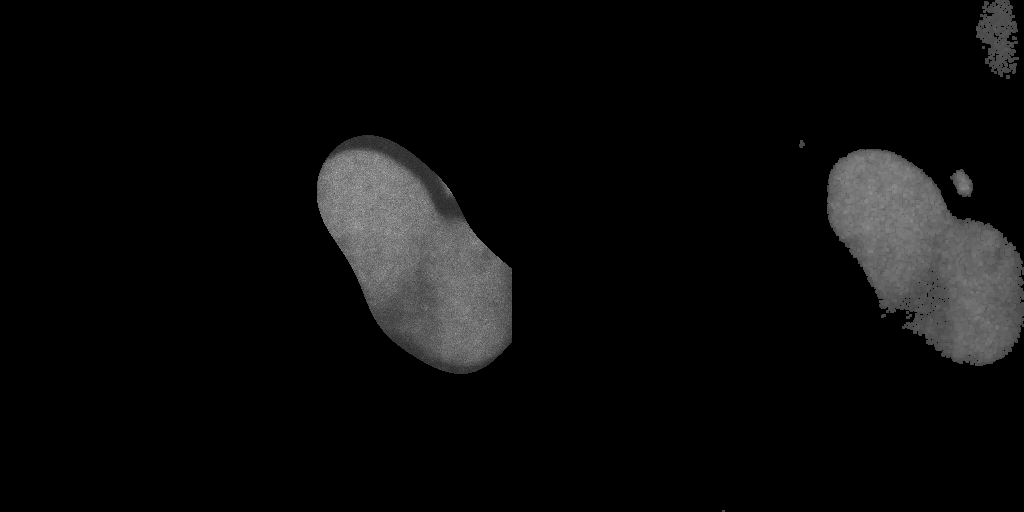

In [238]:
[Gray.(d16s1_cel[6][:, :, 20*16+14].*100 .*mask_6_16) Gray.(opening(d16s1_cel[6][:, :, 20*16+14] .* (d16s1_cel[6][:,:,20*16+14].>yen) ).*100 ) ]

In [211]:
@time nucleus, thres = extract3dnucleus(d16s1_cel_direct[1]);

119.954822 seconds (3.66 M allocations: 32.789 GiB, 32.56% gc time)


In [213]:
include("tiffxml.jl")

embedxml

In [215]:
save("d16s1_1_3d.tiff", N0f16.(nucleus))
embedxml(512, 512, 20, 138, "d16s1_1_3d.tiff")

Embedding OME-XML    1 image files updated


In [244]:
mask6_16_3d = zeros(512, 512, 20)
for i in 1:20
    mask6_16_3d[:,:,i] =mask_6_16
end

In [219]:
norm, para_norm = normalize(nucleus)
save("d16s1_1_3d_nor.tiff", N0f16.(norm))
embedxml(512, 512, 20, 138, "d16s1_1_3d_nor.tiff")

Embedding OME-XML    1 image files updated


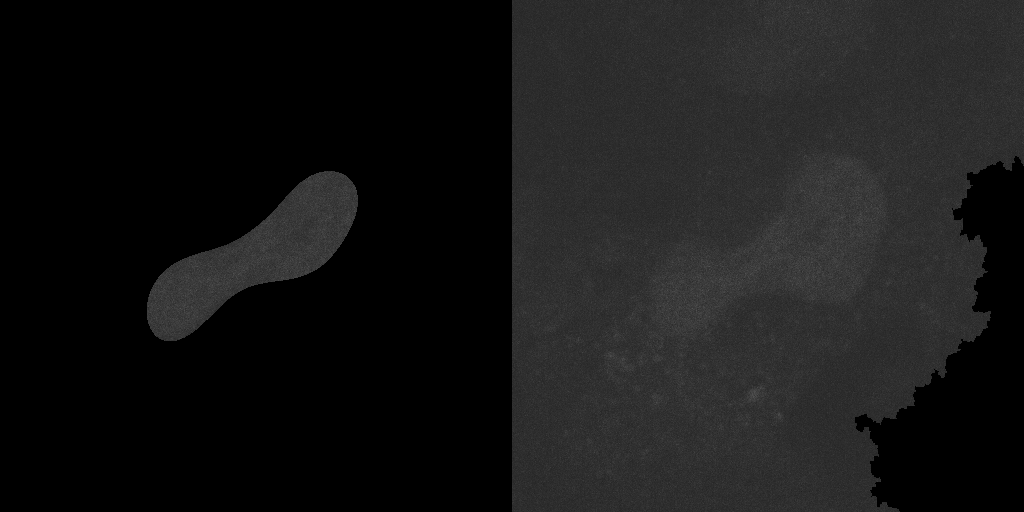

In [205]:
[Gray.(d16s1_cel_direct[1][:,:,15].*100) Gray.(d16s1_cel[1][:,:,15].*100)]

In [199]:
for i in 1:length(longlived_label_2)
    print("saving $(longlived_label_2[i]) ")
    save("d16_s1-$(longlived_label_2[i]).tiff", N0f16.(d16s1_cel_direct[i]))
end

saving 4 saving 5 saving 9 saving 11 saving 12 saving 15 saving 27 saving 31 saving 53 saving 100 saving 101 saving 102 saving 103 

""

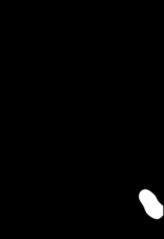

In [181]:
[ Gray.(time_line_2[:, :, 16].==longlived_label_2[6]) ]

In [184]:
maximum(d16s1_cel[13][:, :, 14+20*3])

0.0

In [153]:
d1, d2 = Int.(floor.(centroids[:, 1, 12]))

2-element Array{Int64,1}:
  564
 1160

In [167]:
box_1 = box(centroids[:, 1, 12], 1900, 1300)

(213:914, 601:1300)

""

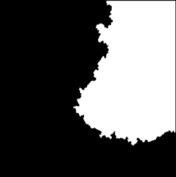

In [248]:
[Gray.(watertest.image_indexmap[box_1[1], box_1[2]].==102)] #Gray.(watertest.image_indexmap .==label) Gray.(time_line_2[:,:, 1] .==label) ]